## Dependencies

In [1]:
import gc
import re
import warnings
from joblib import dump
import tensorflow_hub as hub
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation, Average, Add, Reshape, Attention
from tensorflow.keras.layers import GlobalAveragePooling1D, Embedding, LSTM, Conv1D, SpatialDropout1D, Bidirectional, Flatten, Bidirectional
from googleqa_utilityscript import *
from script_lr_schedulers import LRFinder, CyclicLR


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [2]:
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/model.h5'
tokenizer_path = '/kaggle/working/tokenizer.joblib'
encoder_path = '/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'
category_encoder_path = '/kaggle/working/category_encoder.joblib'
host_encoder_path = '/kaggle/working/host_encoder.joblib'
scaler_path = '/kaggle/working/scaler.joblib'

hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
test = pd.read_csv('/kaggle/input/google-quest-challenge/test.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    test[feature] = test[feature].apply(lambda x: x.lower())


# Text length
train['question_title_len'] = train['question_title'].apply(lambda x : len(x))
validation['question_title_len'] = validation['question_title'].apply(lambda x : len(x))
train['question_body_len'] = train['question_body'].apply(lambda x : len(x))
validation['question_body_len'] = validation['question_body'].apply(lambda x : len(x))
train['answer_len'] = train['answer'].apply(lambda x : len(x))
validation['answer_len'] = validation['answer'].apply(lambda x : len(x))

# Word count
train['question_title_word_cnt'] = train['question_title'].apply(lambda x : len(x.split(' ')))
validation['question_title_word_cnt'] = validation['question_title'].apply(lambda x : len(x.split(' ')))
train['question_body_word_cnt'] = train['question_body'].apply(lambda x : len(x.split(' ')))
validation['question_body_word_cnt'] = validation['question_body'].apply(lambda x : len(x.split(' ')))
train['answer_word_cnt'] = train['answer'].apply(lambda x : len(x.split(' ')))
validation['answer_word_cnt'] = validation['answer'].apply(lambda x : len(x.split(' ')))

# Unique word count
train['question_title_unique_word_cnt'] = train['question_title'].apply(lambda x : len(set(x.split(' '))))
validation['question_title_unique_word_cnt'] = validation['question_title'].apply(lambda x : len(set(x.split(' '))))
train['question_body_unique_word_cnt'] = train['question_body'].apply(lambda x : len(set(x.split(' '))))
validation['question_body_unique_word_cnt'] = validation['question_body'].apply(lambda x : len(set(x.split(' '))))
train['answer_unique_word_cnt'] = train['answer'].apply(lambda x : len(set(x.split(' '))))
validation['answer_unique_word_cnt'] = validation['answer'].apply(lambda x : len(set(x.split(' '))))

# Misspelings count
misspelling_mapping_set = set(misspelling_mapping.keys())
train['question_title_misspelings_cnt'] = train['question_title'].apply(lambda x : len(set(x.split(' ')) & misspelling_mapping_set))
validation['question_title_misspelings_cnt'] = validation['question_title'].apply(lambda x : len(set(x.split(' ')) & misspelling_mapping_set))
train['question_body_misspelings_cnt'] = train['question_body'].apply(lambda x : len(set(x.split(' ')) & misspelling_mapping_set))
validation['question_body_misspelings_cnt'] = validation['question_body'].apply(lambda x : len(set(x.split(' ')) & misspelling_mapping_set))
train['answer_misspelings_cnt'] = train['answer'].apply(lambda x : len(set(x.split(' ')) & misspelling_mapping_set))
validation['answer_misspelings_cnt'] = validation['answer'].apply(lambda x : len(set(x.split(' ')) & misspelling_mapping_set))

# Meta features
train['question_title_count'] = train['question_title'].apply(lambda x : x.count('?'))
validation['question_title_count'] = validation['question_title'].apply(lambda x : x.count('?'))
train['question_body_count'] = train['question_body'].apply(lambda x : x.count('?'))
validation['question_body_count'] = validation['question_body'].apply(lambda x : x.count('?'))
train['title_exp_count'] = train['question_title'].apply(lambda x : x.count('why'))
validation['title_exp_count'] = validation['question_title'].apply(lambda x : x.count('why'))
train['body_exp_count'] = train['question_body'].apply(lambda x : x.count('why'))
validation['body_exp_count'] = validation['question_body'].apply(lambda x : x.count('why'))
train['title_choice_count'] = train['question_title'].apply(lambda x : x.count('or'))
validation['title_choice_count'] = validation['question_title'].apply(lambda x : x.count('or'))
train['body_choice_count'] = train['question_body'].apply(lambda x : x.count('or'))
validation['body_choice_count'] = validation['question_body'].apply(lambda x : x.count('or'))
train['question_aswer_ratio'] = train['question_title_word_cnt'] / train['answer_word_cnt']
validation['question_aswer_ratio'] = validation['question_title_word_cnt'] / validation['answer_word_cnt']
train['same_author'] = train['question_user_page'] == train['answer_user_page']
validation['same_author'] = validation['question_user_page'] == validation['answer_user_page']


for feature in text_features:
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    test[feature] = test[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())
    test[feature] = test[feature].apply(lambda x: x.strip())

for feature in text_features:
    train[feature + '_uncased'] = train[feature]
    validation[feature + '_uncased'] = validation[feature]
    test[feature + '_uncased'] = test[feature]

# Model parameters

In [5]:
EPOCHS = 30
BATCH_SIZE = 64
STEP_SIZE_TRAIN = len(train) // BATCH_SIZE
LEARNING_RATE = 1e-0
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 20 #8
RLROP_PATIENCE = 3
DECAY_DROP = 0.1
MAX_FEATURES = 100000
TITLE_MAX_LEN = 30
BODY_MAX_LEN = 100
ANSWER_MAX_LEN = 100
MIN_LEARNING_RATE = 1e-5
CYCLE_LENGTH = 6
STEP_SIZE = (CYCLE_LENGTH // 2) * STEP_SIZE_TRAIN

In [6]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True)

tokenizer.fit_on_texts(list(train['question_title_uncased']) + list(validation['question_title_uncased']) + list(test['question_title_uncased']) +
                       list(train['question_body_uncased']) + list(validation['question_body_uncased']) + list(test['question_body_uncased']) +
                       list(train['answer_uncased']) + list(validation['answer_uncased']) + list(test['answer_uncased']))

## Train/validation sets

In [7]:
ohe_category = OneHotEncoder(handle_unknown='ignore')
ohe_host = OneHotEncoder(handle_unknown='ignore')
ohe_category = ohe_category.fit(train[['category']])
ohe_host = ohe_host.fit(train[['host']])
scaler = MinMaxScaler()


# Train features
# X_train_title = train['question_title']
# X_train_body = train['question_body']
# X_train_answer = train['answer']
X_train_title_seq = train['question_title_uncased']
X_train_body_seq = train['question_body_uncased']
X_train_answer_seq = train['answer_uncased']
X_train_category = ohe_category.transform(train[['category']]).toarray()
X_train_host = ohe_host.transform(train[['host']]).toarray()
X_train_dense = train[['question_title_len', 'question_title_word_cnt', 'question_title_unique_word_cnt', 
                       'question_title_misspelings_cnt',  'question_body_len', 'question_body_word_cnt', 
                       'question_body_unique_word_cnt', 'question_body_misspelings_cnt', 
                       'answer_len', 'answer_word_cnt', 'answer_unique_word_cnt', 'answer_misspelings_cnt', 
                       'question_title_count', 'question_body_count', 'title_exp_count', 'body_exp_count', 
                       'title_choice_count',  'body_choice_count', 'body_choice_count', 
                       'question_aswer_ratio', 'same_author']]


# Tokenize the sentences
X_train_title_seq = tokenizer.texts_to_sequences(X_train_title_seq)
X_train_body_seq = tokenizer.texts_to_sequences(X_train_body_seq)
X_train_answer_seq = tokenizer.texts_to_sequences(X_train_answer_seq)

# Pad the sentences
X_train_title_seq = pad_sequences(X_train_title_seq, maxlen=TITLE_MAX_LEN)
X_train_body_seq = pad_sequences(X_train_body_seq, maxlen=BODY_MAX_LEN)
X_train_answer_seq = pad_sequences(X_train_answer_seq, maxlen=ANSWER_MAX_LEN)

scaler.fit(X_train_dense)
X_train_dense = scaler.transform(X_train_dense)

X_train = [X_train_title_seq, X_train_body_seq, X_train_answer_seq, X_train_category, X_train_host, X_train_dense]
Y_train = train[target_cols].values

# Validation features
# X_valid_title = validation['question_title']
# X_valid_body = validation['question_body']
# X_valid_answer = validation['answer']
X_valid_title_seq = validation['question_title_uncased']
X_valid_body_seq = validation['question_body_uncased']
X_valid_answer_seq = validation['answer_uncased']
X_valid_category = ohe_category.transform(validation[['category']]).toarray()
X_valid_host = ohe_host.transform(validation[['host']]).toarray()
X_valid_dense = validation[['question_title_len', 'question_title_word_cnt', 'question_title_unique_word_cnt', 'question_title_misspelings_cnt', 
                            'question_body_len', 'question_body_word_cnt', 'question_body_unique_word_cnt', 'question_body_misspelings_cnt', 
                            'answer_len', 'answer_word_cnt', 'answer_unique_word_cnt', 'answer_misspelings_cnt', 
                            'question_title_count', 'question_body_count', 'title_exp_count', 'body_exp_count', 'title_choice_count', 
                            'body_choice_count', 'body_choice_count', 'question_aswer_ratio', 'same_author']]

# Tokenize the sentences
X_valid_title_seq = tokenizer.texts_to_sequences(X_valid_title_seq)
X_valid_body_seq = tokenizer.texts_to_sequences(X_valid_body_seq)
X_valid_answer_seq = tokenizer.texts_to_sequences(X_valid_answer_seq)

# Pad the sentences
X_valid_title_seq = pad_sequences(X_valid_title_seq, maxlen=TITLE_MAX_LEN)
X_valid_body_seq = pad_sequences(X_valid_body_seq, maxlen=BODY_MAX_LEN)
X_valid_answer_seq = pad_sequences(X_valid_answer_seq, maxlen=ANSWER_MAX_LEN)

X_valid_dense = scaler.transform(X_valid_dense)

X_valid = [X_valid_title_seq, X_valid_body_seq, X_valid_answer_seq, X_valid_category, X_valid_host, X_valid_dense]
Y_valid = validation[target_cols].values


print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model

In [8]:
# use_embed = hub.load(module_url)

# def USEEmbedding(x):
#     return use_embed(tf.squeeze(tf.cast(x, tf.string)))

# def encoder_block(input_layer):
#     encoder = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_layer)
    
#     return encoder

## Load embedding

In [9]:
glove_embedding_matrix, glove_unknown_words = build_matrix(tokenizer.word_index, encoder_path, MAX_FEATURES)
print('n unknown words (GloVe): ', len(glove_unknown_words))

n unknown words (GloVe):  19913


In [10]:
# Title sequence
input_title_seq = Input(shape=(TITLE_MAX_LEN,), dtype=tf.float32, name='input_title_seq')
title = Embedding(*glove_embedding_matrix.shape, weights=[glove_embedding_matrix], trainable=False)(input_title_seq)
title = SpatialDropout1D(0.3)(title)
title = Bidirectional(LSTM(128, kernel_initializer='glorot_uniform'))(title)
title = Dropout(0.5)(title)
title = Dense(512, kernel_initializer='glorot_uniform')(title)
title = BatchNormalization()(title)
title_out = Activation('relu')(title)

# Body sequence
input_body_seq = Input(shape=(BODY_MAX_LEN,), dtype=tf.float32, name='input_body_seq')
body = Embedding(*glove_embedding_matrix.shape, weights=[glove_embedding_matrix], trainable=False)(input_body_seq)
body = SpatialDropout1D(0.3)(body)
body = Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='glorot_uniform'))(body)
body = Bidirectional(LSTM(128, kernel_initializer='glorot_uniform'))(body)
body = Dropout(0.5)(body)
body = Dense(512, kernel_initializer='glorot_uniform')(body)
body = BatchNormalization()(body)
body_out = Activation('relu')(body)

# Answer sequence
input_answer_seq = Input(shape=(ANSWER_MAX_LEN,), dtype=tf.float32, name='input_answer_seq')
answer = Embedding(*glove_embedding_matrix.shape, weights=[glove_embedding_matrix], trainable=False)(input_answer_seq)
answer = SpatialDropout1D(0.3)(answer)
answer = Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='glorot_uniform'))(answer)
answer = Bidirectional(LSTM(128, kernel_initializer='glorot_uniform'))(answer)
answer = Dropout(0.5)(answer)
answer = Dense(512, kernel_initializer='glorot_uniform')(answer)
answer = BatchNormalization()(answer)
answer_out = Activation('relu')(answer)

# Category
input_category = Input(shape=(X_train_category.shape[1],), dtype=tf.float32, name='input_category')
category = Embedding(X_train_category.shape[1], X_train_category.shape[1]//2)(input_category)
category_out = GlobalAveragePooling1D()(category)

# Host
input_host = Input(shape=(X_train_host.shape[1],), dtype=tf.float32, name='input_host')
host = Embedding(X_train_host.shape[1], X_train_host.shape[1]//2)(input_host)
host_out = GlobalAveragePooling1D()(host)

# Dense features
input_dense = Input(shape=(X_train_dense.shape[1],), dtype=tf.float32, name='input_dense')

# Output
output = Concatenate()([title_out, body_out, answer_out, category_out, host_out, input_dense])
output = Dropout(0.5)(output)
output = Dense(512, kernel_initializer='glorot_uniform')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.5)(output)
output = Dense(512, kernel_initializer='glorot_uniform')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dense(N_CLASS, activation='sigmoid', kernel_initializer='glorot_uniform')(output)

model = Model(inputs=[input_title_seq, input_body_seq, input_answer_seq, input_category, input_host, input_dense], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_body_seq (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_answer_seq (InputLayer)   [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_title_seq (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     17402100    input_body_seq[0][0]             
______________________________________________________________________________________________

## Learning rate finder

Train on 4863 samples
4863/4863 [==============================] - 249s 51ms/sample - loss: nan


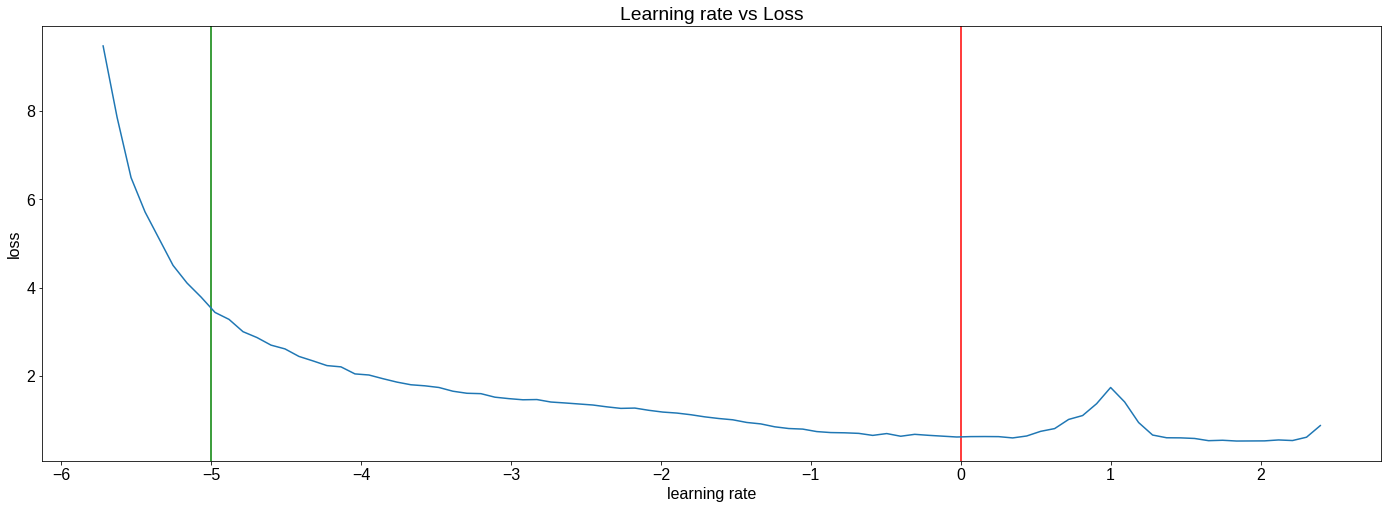

In [11]:
cold_weights = model.get_weights()
lr_finder = LRFinder(num_samples=len(train), batch_size=BATCH_SIZE, minimum_lr=1e-6, maximum_lr=10, verbose=0)

optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    epochs=1, 
                    callbacks=[lr_finder])

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(24, 8))
plt.axvline(x=np.log10(LEARNING_RATE), color='red')
plt.axvline(x=np.log10(MIN_LEARNING_RATE), color='green')
lr_finder.plot_schedule(clip_beginning=3)

# Train model

In [12]:
model.set_weights(cold_weights)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid), monitor='val_loss', mode='min', patience=ES_PATIENCE)
cyclicalLR = CyclicLR(base_lr=MIN_LEARNING_RATE, max_lr=LEARNING_RATE, step_size=STEP_SIZE, mode='triangular2')

callback_list = [spearmanCallback, cyclicalLR]

optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/30
spearman-rho: 0.1408 val_spearman-rho: 0.1349
4863/4863 - 275s - loss: 0.4948 - val_loss: 0.5565
Epoch 2/30
spearman-rho: 0.2295 val_spearman-rho: 0.2216
4863/4863 - 258s - loss: 0.4272 - val_loss: 0.4590
Epoch 3/30
spearman-rho: 0.2304 val_spearman-rho: 0.2186
4863/4863 - 253s - loss: 0.4165 - val_loss: 0.4691
Epoch 4/30
spearman-rho: 0.2685 val_spearman-rho: 0.2487
4863/4863 - 254s - loss: 0.4105 - val_loss: 0.4244
Epoch 5/30
spearman-rho: 0.2979 val_spearman-rho: 0.2784
4863/4863 - 253s - loss: 0.4031 - val_loss: 0.4120
Epoch 6/30
spearman-rho: 0.3076 val_spearman-rho: 0.2849
4863/4863 - 253s - loss: 0.3976 - val_loss: 0.4015
Epoch 7/30
spearman-rho: 0.3109 val_spearman-rho: 0.2912
4863/4863 - 254s - loss: 0.3966 - val_loss: 0.3982
Epoch 8/30
spearman-rho: 0.3078 val_spearman-rho: 0.2881
4863/4863 - 253s - loss: 0.3968 - val_loss: 0.3999
Epoch 9/30
spearman-rho: 0.3121 val_spearman-rho: 0.2914
4863/4863 - 253s - loss: 0.3974

## Scheduler learning rates

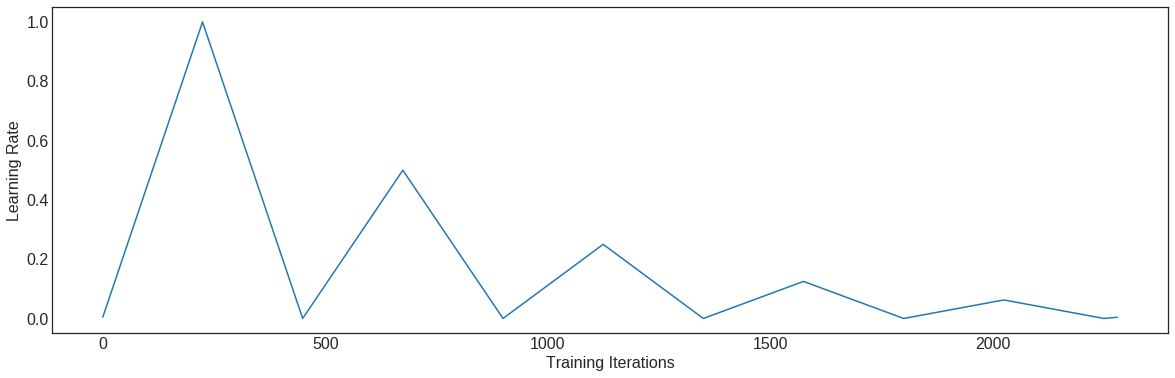

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.plot(cyclicalLR.history['lr'])
plt.show()

## Model loss graph

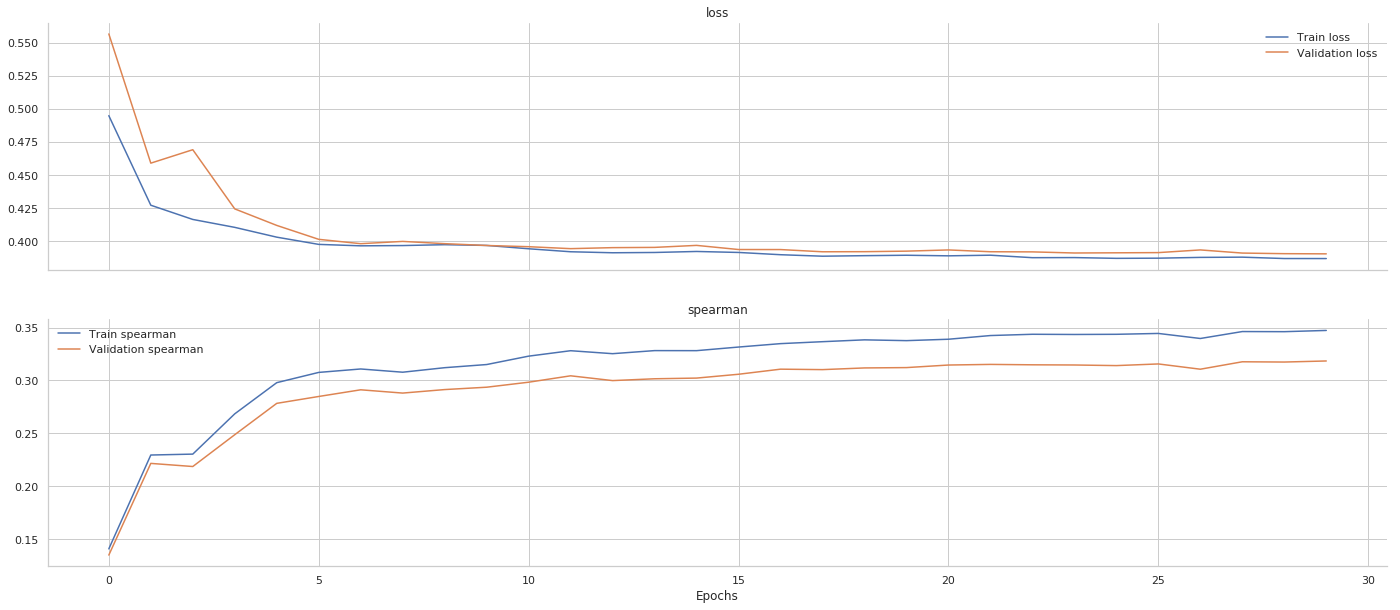

In [14]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [15]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols).style.applymap(color_map))

,Label,Train,Validation
0,Averaged,0.347,0.318
1,question_asker_intent_understanding,0.335,0.393
2,question_body_critical,0.607,0.555
3,question_conversational,0.395,0.366
4,question_expect_short_answer,0.254,0.205
5,question_fact_seeking,0.337,0.249
6,question_has_commonly_accepted_answer,0.411,0.412
7,question_interestingness_others,0.333,0.336
8,question_interestingness_self,0.45,0.439
9,question_multi_intent,0.355,0.34


## By category

In [16]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category').style.applymap(color_map))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.305,0.28,0.356,0.285,0.234,0.195,0.337,0.296,0.303,0.288


#### Save model weights and ecoders

In [17]:
model.save_weights(model_path)
dump(tokenizer, tokenizer_path)
dump(ohe_category, category_encoder_path)
dump(ohe_host, host_encoder_path)
dump(scaler, scaler_path)

['/kaggle/working/scaler.joblib']